In [110]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [66]:
csv_path = "../datasets/PlantDoc.csv"
seed = 19
validation_ratio = 0.2

In [75]:
df_full = pd.read_csv(csv_path, index_col=0)
df_train, df_valid = train_test_split(
    df_full, test_size=validation_ratio, stratify=df_full["target"]
)

df_train_targets = df_train["target"]
df_train_features = df_train.loc[:, ~df_train.columns.isin(["target"])]
print(df_train_targets.value_counts()[:5])

df_valid_targets = df_valid["target"]
df_valid_features = df_valid.loc[:, ~df_valid.columns.isin(["target"])]
print(df_valid_targets.value_counts()[:5])

target
8     144
18    112
15     99
13     89
11     87
Name: count, dtype: int64
target
8     36
18    28
15    25
13    23
11    22
Name: count, dtype: int64


In [ ]:
#TODO: scaler!

In [76]:
tsne = TSNE(n_components=2, random_state=seed)
df_train_features_reduced = tsne.fit_transform(X=df_train_features)

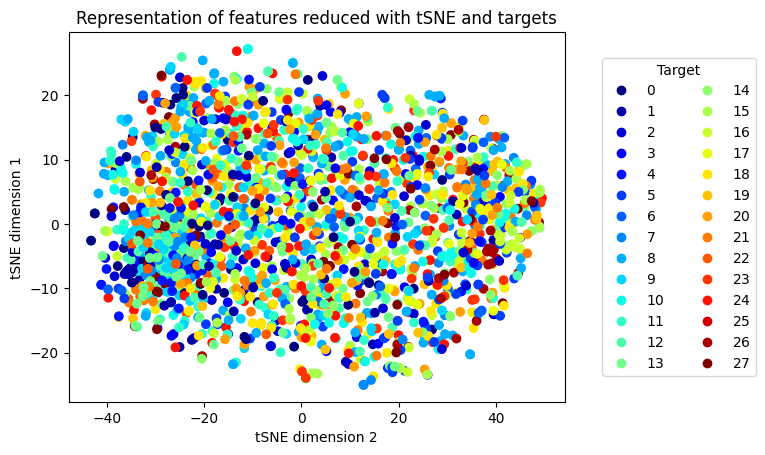

In [77]:
# plt.figure(figsize=(12, 5))
plt.title(f"Representation of features reduced with tSNE and targets")
plt.ylabel("tSNE dimension 1")
plt.xlabel("tSNE dimension 2")
scatter = plt.scatter(
    df_train_features_reduced[:, 0],
    df_train_features_reduced[:, 1],
    c=df_train_targets,
    # s=df.gdp/100,
    cmap="jet",
)
# plt.legend(range(0,16))
plt.legend(
    *scatter.legend_elements(num=df_train_targets.unique().size),
    title="Target",
    ncol=2,
    loc="right",
    bbox_to_anchor=(1.4, 0.5),
)
plt.show()

Accuracy with 1 neighbors: 0.1513859275053305
Accuracy with 2 neighbors: 0.13646055437100213
Accuracy with 3 neighbors: 0.14498933901918976
Accuracy with 4 neighbors: 0.14072494669509594
Accuracy with 5 neighbors: 0.1300639658848614
Accuracy with 6 neighbors: 0.1300639658848614
Accuracy with 7 neighbors: 0.1300639658848614
Accuracy with 8 neighbors: 0.1257995735607676
Accuracy with 9 neighbors: 0.13219616204690832
Accuracy with 10 neighbors: 0.1300639658848614
Accuracy with 11 neighbors: 0.11300639658848614
Accuracy with 12 neighbors: 0.10874200426439233
Accuracy with 13 neighbors: 0.11513859275053305
Accuracy with 14 neighbors: 0.10874200426439233
Accuracy with 15 neighbors: 0.10021321961620469
Accuracy with 16 neighbors: 0.09594882729211088
Accuracy with 17 neighbors: 0.09594882729211088
Accuracy with 18 neighbors: 0.1023454157782516
Accuracy with 19 neighbors: 0.10660980810234541
Accuracy with 20 neighbors: 0.1023454157782516
Accuracy with 21 neighbors: 0.1023454157782516
Accuracy w

Text(0, 0.5, 'Accuracy')

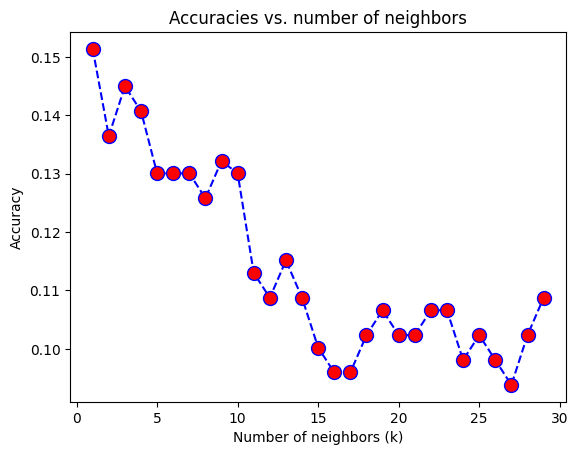

In [96]:
accuracies = []
max_neighbors = 30
for i in range(1, max_neighbors):
    model_knn = KNeighborsClassifier(n_neighbors=i)
    model_knn.fit(df_train_features, df_train_targets)
    valid_pred = model_knn.predict(df_valid_features)
    accuracy = accuracy_score(df_valid_targets, valid_pred)
    accuracies.append(accuracy)
    print(f"Accuracy with {i} neighbors: {accuracy}")

# plt.figure(figsize=(10,6))
plt.plot(
    range(1, max_neighbors),
    accuracies,
    color="blue",
    linestyle="dashed",
    marker="o",
    markerfacecolor="red",
    markersize=10,
)
plt.title("Accuracies vs. number of neighbors")
plt.xlabel("Number of neighbors (k)")
plt.ylabel("Accuracy")

In [103]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(df_train_features, df_train_targets)

valid_pred = model_lr.predict(df_valid_features)

In [105]:
accuracy = accuracy_score(df_valid_targets, valid_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.1279317697228145
